<a href="https://colab.research.google.com/github/tnfru/colab_research/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sys
if 'google.colab' in sys.modules:
  %tensorflow_version 2.x
import tensorflow as tf
from google.colab import drive
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
import copy

AUTO = tf.data.experimental.AUTOTUNE

TensorFlow 2.x selected.


Using TensorFlow backend.


## Set up TPU

In [2]:
try: 
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus)
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Running on  1  GPU(s) 


## Read Data from Google Drive

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH="/content/drive/My Drive/data/CIFAR10/"

In [0]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
db_1 = unpickle(PATH + "data_batch_1")
db_2 = unpickle(PATH + "data_batch_2")
db_3 = unpickle(PATH + "data_batch_3")
db_4 = unpickle(PATH + "data_batch_4")
db_5 = unpickle(PATH + "data_batch_5")
test_data = unpickle(PATH + "test_batch")
meta = unpickle(PATH + "batches.meta")

In [7]:
db_1[b'data'].shape, len(db_1[b'labels'])

((10000, 3072), 10000)

## Transform data

In [0]:
IMG_SIZE = [32, 32]
BATCH_SIZE = 128

In [9]:
X = np.append(db_1[b'data'], db_2[b'data'], axis=0)
X = np.append(X, db_3[b'data'], axis=0)
X = np.append(X, db_4[b'data'], axis=0)
X = np.append(X, db_5[b'data'], axis=0)
X = X.reshape(-1, *IMG_SIZE, 3)
X.shape

(50000, 32, 32, 3)

In [10]:
Y = copy.copy(db_1[b'labels'])
Y.extend(db_2[b'labels'])
Y.extend(db_3[b'labels'])
Y.extend(db_4[b'labels'])
Y.extend(db_5[b'labels'])
Y = np.array(Y)
Y = to_categorical(Y.reshape(-1, 1), num_classes=10)
Y.shape

(50000, 10)

In [11]:
X_test = test_data[b'data'].reshape(-1, *IMG_SIZE, 3)
Y_test = to_categorical(np.array(test_data[b'labels']).reshape(-1, 1), num_classes=10)
X_test.shape, Y_test.shape

((10000, 32, 32, 3), (10000, 10))

## Heal and normalize data

In [12]:
 np.isnan(X).sum()

0

In [0]:
X = X / 255
X_test = X_test / 255
X = X - X.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

In [14]:
X.mean()

-1.2150526510860496e-14

In [0]:
X = X / X.std(axis=0)
X_test = X_test / X_test.std(axis=0)

In [16]:
X.std(axis=0).sum() / (32 * 32 * 3)

1.000000000000001

## Convert Data to batches

In [0]:
def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.repeat()
    dataset = dataset.shuffle(1337)

  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO)
  return dataset

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

train = get_batched_dataset(train_dataset, train=True)
test = get_batched_dataset(test_dataset)

In [0]:
l = tf.keras.layers

In [0]:
def create_model():
  model = tf.keras.Sequential([
    l.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu', input_shape=(*IMG_SIZE, 3)),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),

    l.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),
    
    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.MaxPooling2D(),
    l.Dropout(0.5),

    l.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    l.BatchNormalization(),
    l.Flatten(),
    l.Dense(10, activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  return model

In [21]:
with strategy.scope():
  model = create_model()

  model.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [0]:
def lr_fun(x):
  return 1e-3 * 0.95 ** x

In [0]:
def display_training_curves(training, validation, title, subplot):
  #stolen from google cnn tutorial
  if subplot%10==1:
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

In [24]:
meta[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [25]:
EPOCHS = 35

annealer = tf.keras.callbacks.LearningRateScheduler(lr_fun)
steps_per_epoch = X.shape[0] // BATCH_SIZE

history = model.fit(train, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=test, callbacks=[annealer], verbose=1)

Train for 390 steps, validate for 79 steps
Epoch 1/35
390/390 [==============================] - 19s 49ms/step - loss: 1.8837 - accuracy: 0.3428 - val_loss: 2.0828 - val_accuracy: 0.3257
Epoch 2/35
390/390 [==============================] - 7s 18ms/step - loss: 1.5175 - accuracy: 0.4565 - val_loss: 1.7257 - val_accuracy: 0.4343
Epoch 3/35
390/390 [==============================] - 7s 18ms/step - loss: 1.3822 - accuracy: 0.5032 - val_loss: 1.4859 - val_accuracy: 0.5041
Epoch 4/35
390/390 [==============================] - 7s 18ms/step - loss: 1.2849 - accuracy: 0.5426 - val_loss: 1.4602 - val_accuracy: 0.5195
Epoch 5/35
390/390 [==============================] - 7s 18ms/step - loss: 1.2230 - accuracy: 0.5670 - val_loss: 1.2761 - val_accuracy: 0.5664
Epoch 6/35
390/390 [==============================] - 7s 18ms/step - loss: 1.1569 - accuracy: 0.5873 - val_loss: 1.2038 - val_accuracy: 0.5911
Epoch 7/35
390/390 [==============================] - 7s 18ms/step - loss: 1.1082 - accuracy: 0.61

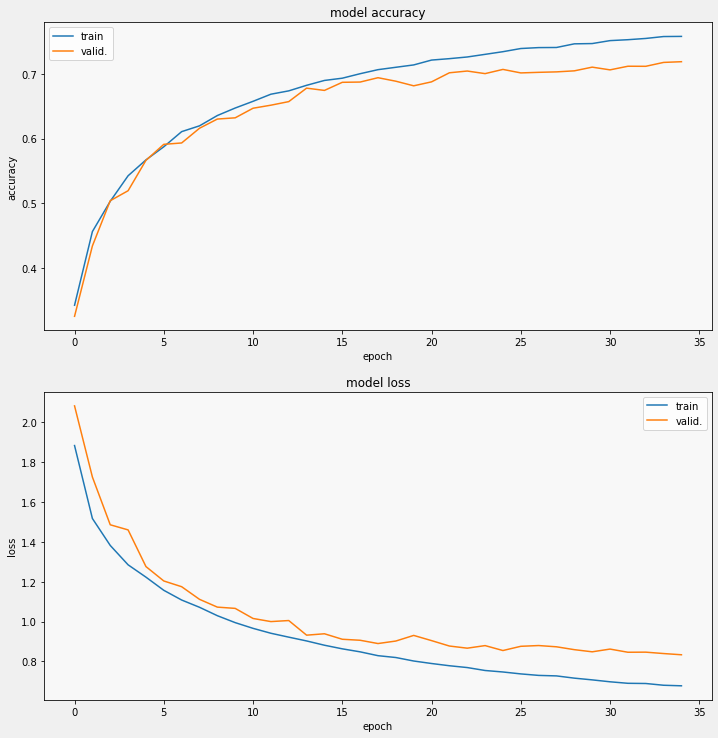

In [26]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)